In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

# Our model

We observe $X_i$, which is the number of messages arrived at a certain location at day $i$ with $i \in \{0,...,n-1\}$, so that we have $n$ days.

We were usually receiving the messages following $\sim \text{Poisson}(2)$, but after a certain day the behaviour changed and we received more messages per day, following $\sim \text{Poisson}(4)$.


$$\begin{align*}
\tau &\in (0,1)\\
\text{for }  i &= 1\ldots N: \\
X_i &= \begin{cases} \text{Poisson}(2), & \tau > i/N \\ \text{Poisson}(4), & \text{otherwise}\end{cases}\\
\end{align*}$$

In [2]:
# real (and unknown) parameter
real_tau = 0.8

# possible range of values for tau
tau_support = 0,1

In [3]:
class TModel:
        
    poisson_A = stats.poisson(2)
    poisson_B = stats.poisson(4)

    def __init__(self, tau):        
        assert tau>=0 and tau<=1        
        self.tau = tau
        
    def rvs(self, n):
        n1 = int(n*self.tau)        
        r = list(self.poisson_A.rvs(n1)) + list(self.poisson_B.rvs(n - n1))
        return r
    
    def logprob(self, x):
        n = int(len(x)*self.tau)
        return np.sum(np.log(self.poisson_A.pmf(x[:n]))) + np.sum(np.log(self.poisson_B.pmf(x[n:])))    
         

# Our observations

In [4]:
x = TModel(tau=real_tau).rvs(30)

# use this small sample for comparisons with other notebooks
x = [3, 3, 2, 3, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 3, 2, 0, 3, 2, 2, 2, 2, 2, 1, 1, 5, 6, 2, 3, 4]



Text(0.5, 0, '$\\tau$')

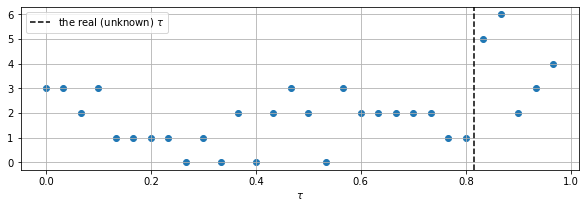

In [5]:
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(x))/len(x), x)
plt.axvline((real_tau*len(x)+.5)/len(x), ls="--", color="black", label=r"the real (unknown) $\tau$")
plt.grid(); plt.legend();
plt.xlabel(r"$\tau$")

# MCMC with Tensorflow

MCMC allows us to sample the posterior **without** computing the normalization constant.

observe:

- the `log_likelihood` function below, implementing our model.
- the `log_prior` uniform uninformative prior.
- the `unnormalized_log_posterior` aggregation function below is the only input to the Hamiltonian Montecarlo sampler.

In [6]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)


def sample(x):
    num_burnin_steps = 5000
    num_results = 20000
    
    # -------------------------------------------------------
    #  our model definitions
    # -------------------------------------------------------    
    def log_likelihood(x, tau):
        lambda_A, lambda_B = 2., 4.

        n = tf.size(x)
        n1 = tf.cast(tf.cast(n, tf.float32)*tau, tf.int32)

        lambdas = tf.concat([tf.ones(n1)*lambda_A, tf.ones(n-n1)*lambda_B], 0)

        return tf.reduce_sum(tfd.Poisson(rate=lambdas).log_prob(x))

    def log_prior(tau):
        return tfd.Uniform().log_prob(tau)

    # -------------------------------------------------------
    # -------------------------------------------------------
    
    
    unnormalized_log_posterior = lambda tau: log_likelihood(x, tau) + log_prior(tau)    


    # Set the chain's start state.
    initial_chain_state = [
        0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
    ]

    # Since HMC operates over unconstrained space, we need to transform the
    # samples so they live in real-space.
    unconstraining_bijectors = [
        tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
    ]

    step_size = 0.2

    kernel=tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_log_posterior,
                num_leapfrog_steps=2,
                step_size=step_size,
                state_gradients_are_stopped=True),
            bijector=unconstraining_bijectors)

    # Sample from the chain.
    [
        posterior_tau
    ], kernel_results = graph_sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_chain_state,
        kernel = kernel)

    return posterior_tau

In [7]:
posterior_tau = sample(x)

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-02-07 12:05:06.566370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 12:05:06.592874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 12:05:06.593050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 12:05:06.593613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(0.0, 1.0)

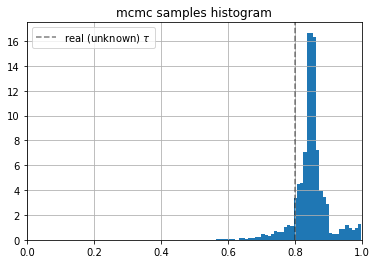

In [8]:
plt.hist(posterior_tau.numpy(), density=True, bins=50, alpha=1.);
plt.axvline(real_tau, color="black", label=r"real (unknown) $\tau$", alpha=.5, ls="--")
plt.title("mcmc samples histogram")
plt.grid(); plt.legend();

plt.xlim(0,1)


# With a larger dataset

Text(0.5, 0, '$\\tau$')

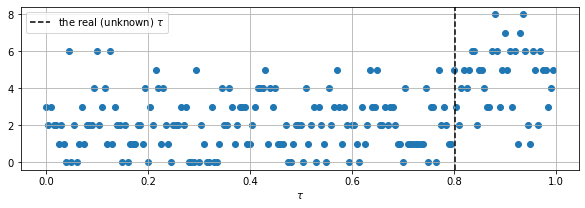

In [9]:
x = TModel(tau=real_tau).rvs(200)

# use this large sample for comparisons with other notebooks
x = [3, 2, 3, 2, 2, 1, 2, 1, 0, 6, 0, 2, 0, 1, 3, 1, 2, 2, 2, 4, 6, 2, 3, 4, 1, 6, 
     1, 3, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 1, 4, 0, 3, 2, 5, 4, 1, 4, 2, 1, 0, 2, 2,
     2, 3, 2, 3, 0, 0, 0, 5, 0, 2, 1, 0, 0, 3, 0, 0, 1, 4, 2, 2, 4, 3, 1, 2, 3, 3, 
     3, 1, 1, 2, 3, 4, 4, 4, 5, 1, 4, 3, 4, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 0, 4, 1, 
     2, 3, 0, 3, 2, 1, 0, 4, 2, 3, 5, 3, 1, 3, 2, 0, 2, 2, 1, 0, 3, 1, 2, 5, 3, 3, 
     5, 2, 2, 3, 2, 3, 3, 2, 1, 1, 0, 4, 1, 1, 1, 1, 1, 1, 1, 4, 0, 3, 3, 0, 5, 2, 
     3, 2, 1, 1, 5, 3, 2, 4, 5, 4, 5, 6, 6, 2, 5, 5, 4, 3, 3, 6, 8, 6, 3, 5, 7, 5, 
     6, 3, 6, 1, 7, 8, 6, 2, 1, 6, 5, 2, 6, 5, 5, 3, 4, 5]

plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(x))/len(x), x)
plt.axvline((real_tau*len(x)+.5)/len(x), ls="--", color="black", label=r"the real (unknown) $\tau$")
plt.grid(); plt.legend();
plt.xlabel(r"$\tau$")

In [10]:
posterior_tau = sample(x)

/opt/anaconda/envs/p39/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


(0.0, 1.0)

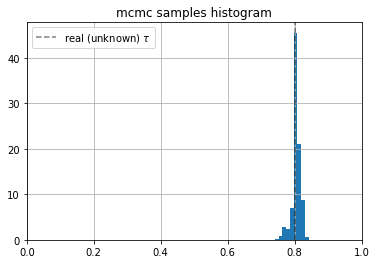

In [11]:
plt.hist(posterior_tau.numpy(), density=True, bins=10, alpha=1.);
plt.axvline(real_tau, color="black", label=r"real (unknown) $\tau$", alpha=.5, ls="--")
plt.title("mcmc samples histogram")
plt.grid(); plt.legend();

plt.xlim(0,1)